# Introducció a OpenCV


En aquesta pràctica veurem algunes utilitats pràctiques d'OpenCV, centrant-nos el processat d'imatges.

## Seguiment de línies

Com a exemple anem a extreure la linea (feta en cinta dhesiva negra) del terra. Extreure la linea del terra és un problema clàssic en robòtica mòbil, ja que és una de les referències més importants per a la navegació

Instalem les llibreries necessàries


In [2]:
%pip install matplotlib opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


Carreguem les llibreries necessàries per a la pràctica.

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Carregant imatges

Quan carreguem imatges en opencv es sol utilitzar una representació com a arrays de NumPy; una dimensió per color.

D'aquesta manera, una imatge en B/N de `542X959` s'enmagatzemarà en un array de `542X959` i si és en color en un array `542X959x3`.


Carreguem la imatge inicial:


(542, 959, 3)


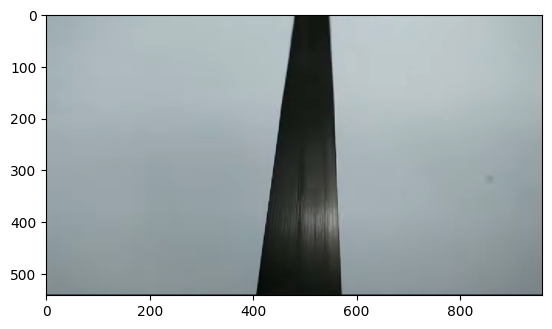

In [4]:
im = cv2.imread("line.png")
print(im.shape)
plt.imshow(im)

Per planificar el següent pas el robot solament necessita la informació de la linea inferior de la imatge. Per això, es pot tallar la imatge per a que solament es processi la part inferior.

Com que la imatge està en format de matriu, es pot fer servir la notació de `slicing` de NumPy per a tallar la imatge. Això es fa amb la notació `img[y1:y2, x1:x2]` on `y1` i `y2` són les coordenades verticals i `x1` i `x2` les horitzontals.

La imatge original té una mida de `542x959` i volem tallar la part inferior de la imatge, per tant, volem deixar la part de la imatge que va des de la fila `200` fins a la `542` i des de la columna `0` fins a la `959`.

(342, 959, 3)


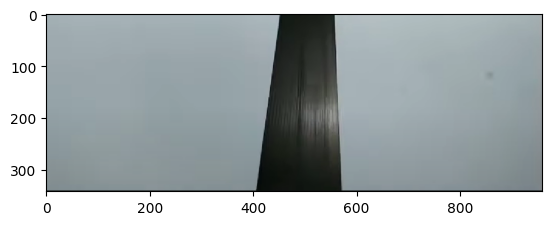

In [5]:
im_baix = im[200:959, 0:959]
print(im_baix.shape)
plt.imshow(im_baix)

### Processem la imatge

Per fer el seguiment de la linea del terra, primer hem de convertir la imatge a escala de grisos. Això ho podem fer amb la funció `cv2.cvtColor`.

(342, 959)


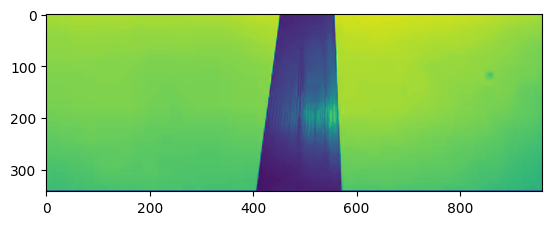

In [6]:
im_bn = cv2.cvtColor(im_baix, cv2.COLOR_BGR2GRAY)
print(im_bn.shape)
plt.imshow(im_bn)

La imatge en escala de grisos és una imatge en la que cada píxel té un valor entre 0 i 255, on 0 és negre i 255 és blanc. Això ens permet treballar amb una sola dimensió i simplificar el processat de la imatge.

Es mostra en colors per a que es vegi millor, però el processat es farà en escala de grisos.


Aplicarem un GaussianBlur per a suavitzar la imatge i eliminar el soroll. Això ho podem fer amb la funció `cv2.GaussianBlur`.

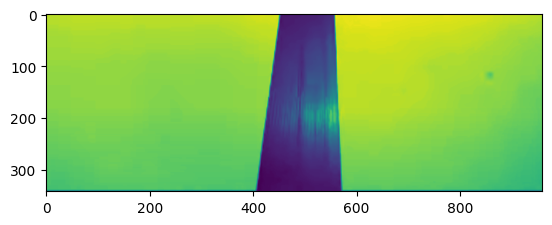

In [7]:
im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
plt.imshow(im_blurred)

### Thresolding

A continuació farem _thresolding_ (separar el fons del primer plà). En aquest [article](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) podem veure ben descrit el procediment.

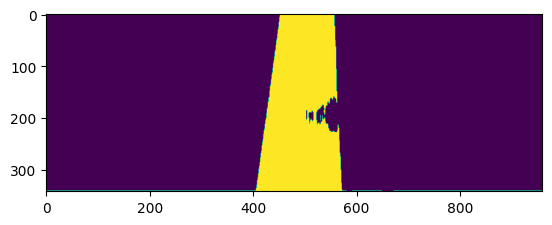

In [8]:
ret, im_th = cv2.threshold(im_blurred,100,255,cv2.THRESH_BINARY_INV)
plt.imshow(im_th)

El mètode més senzill és el _Simple Thresholding_ que simplement compara cada pixel amb un valor i el converteix en blanc o negre segons si és més gran o més petit. Aquest mètode és el més senzill i el més ràpid. Aquest mètode es pot fer servir quan la imatge està ben il·luminada i el fons és fàcil de separar del primer plà.

En el nostre cas hem marcat el valor de _threshold_ a 100, però es pot ajustar segons la imatge.

### Búsqueda de vores

Un cop tenim la imatge binaritzada, podem buscar les vores de la linea. Això ho podem fer amb la funció `cv2.findContours`. Aquesta funció retorna una llista de vores, que són una llista de punts que formen la vora.

Com aquesta funció transforma la imatge, farem una còpia de la imatge binaritzada per a no perdre la imatge original.

In [9]:
im_th_copy = im_th.copy()
contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)

Com que solament ens interessa la vora més gran, verificarem si hi ha més d'una vora i ens quedarem amb la més gran.

Una vegada trobada la vora buscarem el centre de la vora. Això ho podem fer amb la funció `cv2.moments`. Aquesta funció retorna un diccionari amb els moments de la imatge, que ens permeten calcular el centre de la vora. Concretament: `cX = M["m10"] / M["m00"]` i `cY = M["m01"] / M["m00"]`.

### Dibuixem la vora

Finalment, dibuixarem la vora en la imatge original. Això ho podem fer amb la funció `cv2.drawContours` i `cv2.circle` per a dibuixar el centre de la vora.

493 183


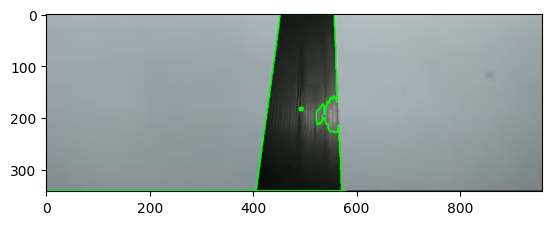

In [10]:
if len(contours) != 0:
    max_contour = max(contours, key = cv2.contourArea)
    center = cv2.moments(max_contour)
    cx = int(center['m10']/center['m00'])
    cy = int(center['m01']/center['m00'])
    print(cx, cy)
    
    cv2.circle(im_baix, (cx, cy), 5,  (0, 255, 0), -1) # 
    cv2.drawContours(im_baix, [max_contour], 0, (0, 255, 0), 2)
    plt.imshow(im_baix)

Per finalitzar simulem el moviment del robot, fent que si el centre de la vora està a la dreta del centre de la imatge 
més d'un cert valor, la vora es mostre de color vermell, i si està a l'esquerra, de color blau.

També agruparem tot el codi en una funció `process_image` que rebrà la imatge com a paràmetre i retornarà la imatge processada.

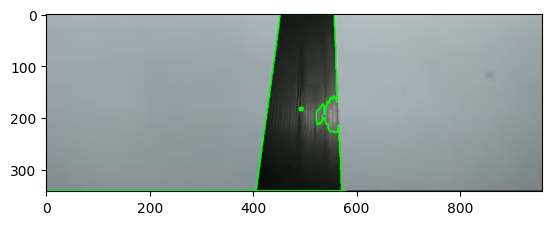

In [11]:
def process_image(im):
    im_baix = im[200:959, 0:959]
    im_bn = cv2.cvtColor(im_baix, cv2.COLOR_BGR2GRAY)
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
    ret, im_th = cv2.threshold(im_blurred,100,255,cv2.THRESH_BINARY_INV)
    im_th_copy = im_th.copy()
    contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
    if len(contours) != 0:
        max_contour = max(contours, key = cv2.contourArea)
        center = cv2.moments(max_contour)
        cx = int(center['m10']/center['m00'])
        cy = int(center['m01']/center['m00'])

        color = (0, 255, 0)

        if cx < 300:
            color = (0, 0, 255)
        elif cx > 600:
            color = (255, 0, 0)

        cv2.circle(im_baix, (cx, cy), 5,  color, -1)
        cv2.drawContours(im_baix, [max_contour], 0, color, 2)

    return im_baix

im = cv2.imread("line.png")
im_proc = process_image(im)
plt.imshow(im_proc)

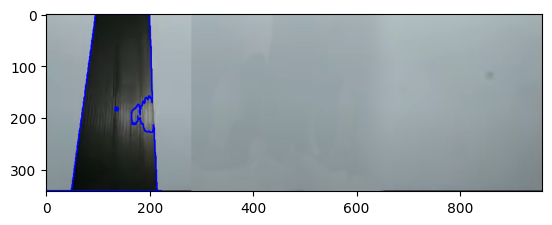

In [12]:
im_left = cv2.imread("line_left.png")
im_proc = process_image(im_left)
plt.imshow(im_proc)

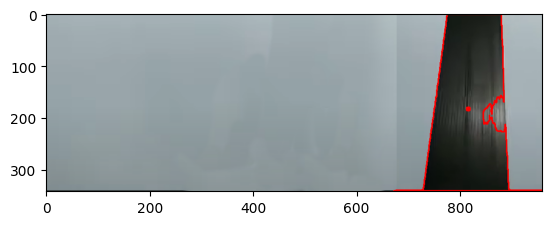

In [13]:
im_right = cv2.imread("line_right.png")
im_proc = process_image(im_right)
plt.imshow(im_proc)

## Detecció de moviment

La detecció de moviment és un problema molt típic en visió per ordinador. Ens permetrà, per exemple, rebre una alerta quan algú entri a casa nostra.

Es poden utilitzar xarxes neuronals per a detectar moviment, però en aquest cas utilitzarem un mètode més senzill, basat en la resta de dos imatges. Si apliquem xarxes neuronals quan ja sabem que ha passat alguna cosa, el cost computacional és molt menor.

La idea a seguir és la següent: les imatges de dos frames consecutius són molt similars, però si hi ha moviment, les imatges seran més diferents. Com representem les imatges com a arrays de NumPy, podem restar un array de l'altre i obtenir un array amb les diferències entre les dues imatges; que serà més gran on hi hagi moviment.

Començarem per carregar un video i convertir-lo en una seqüència d'imatges. Això ho podem fer amb la funció `cv2.VideoCapture`.

Loaded 876 frames


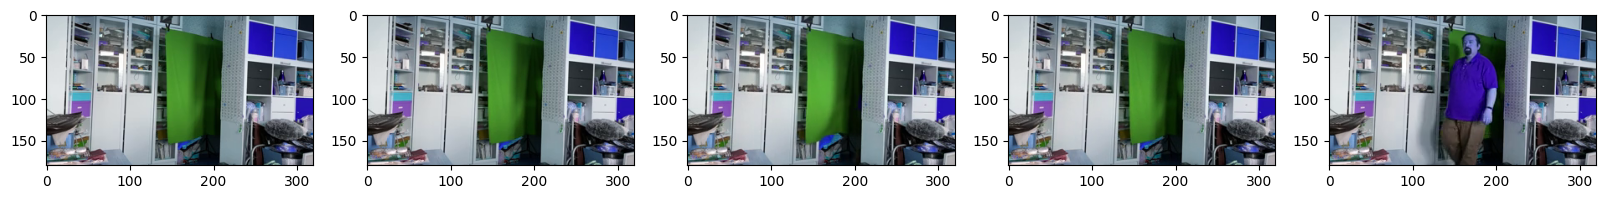

In [14]:
vid = cv2.VideoCapture("motionvideo.mp4")

frames = []
while True:
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)

vid.release()
print(f"Loaded {len(frames)} frames")

# Mostrem els frames de 150 en 150 en una mateixa fila

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(frames[i*150])


El color de la imatge no ens importa, així que la convertirem a escala de grisos.

In [15]:
frames_bn = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]

Ara calcularem la diferència entre dues imatges consecutives. Això ho podem fer amb la resta d'arrays de NumPy.

In [16]:
diffs = [(p2 - p1) for p1, p2 in zip(frames_bn[:-1], frames_bn[1:])]

La norma d'un vector és la longitud (en sentit geomètric) del vector. En el nostre cas, la norma de la resta ens donarà un valor gran on hi hagi moviment i un valor petit on no hi hagi moviment, perquè la resta serà gran on hi hagi moviment i petita on no hi hagi.

Calcularem un vector en les normes de les diferències i mostrarem un gràfic amb aquestes normes, per visualitzar on hi ha moviment.

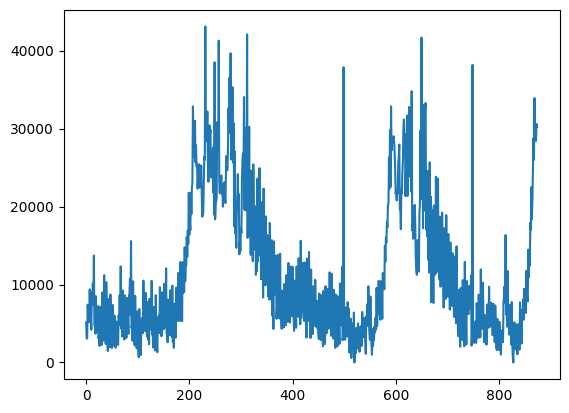

In [17]:
diffs_norms = np.array([np.linalg.norm(x) for x in diffs])

plt.plot(diffs_norms)

Podem veure que hi ha alguns frames en molt de moviment, i altres en que no hi ha moviment. També podem mostrar els diffs com a imatge per visualitzar quines parts de la imatge són les que es mouen.

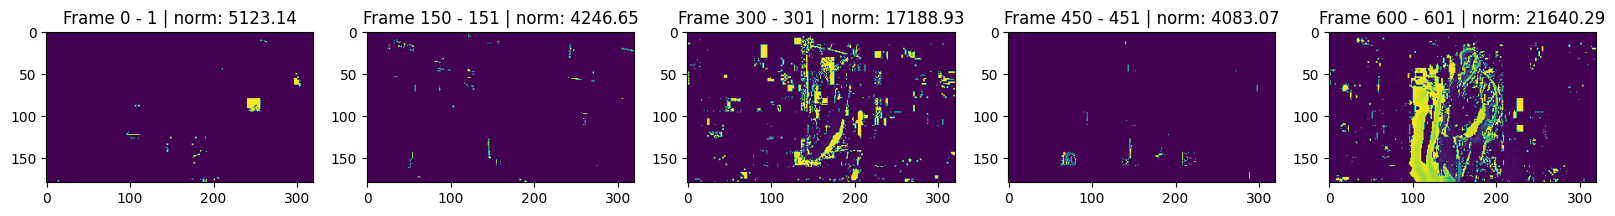

In [18]:
# Mostrem diffs de 150 en 150

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(diffs[i*150])
    axs[i].set_title(f"Frame {i*150} - {i*150+1} | norm: {diffs_norms[i*150]:.2f}")

Per poder mostrar els frames apropiats de cada _event de moviment_ pot ser una bona idea identificar els frames d'inici i final de cada event de moviment i mostrar el frame central de cada event. 

PEr començar marcarem un _threshold_ per a considerar que hi ha moviment i crearem un vector amb els frames on hi ha moviment

In [19]:
thresold = 15000
frames_moviment = [i for i, frame in enumerate(frames) if diffs_norms[i-1] > thresold]

frames_minims_event = 30

# Haurem de buscar les subsequències de frames_moviment que tinguin com a mínim frames_minims_event frames y no siguen consecutius

def find_events(frames_moviment, frames_minims_event):
    events = []
    event = []
    for i, frame in enumerate(frames_moviment):
        if len(event) == 0:
            event.append(frame)
        else:
            if frame - event[-1] == 1:
                event.append(frame)
            else:
                if len(event) >= frames_minims_event:
                    events.append(event)
                event = []
    return events

events = find_events(frames_moviment, frames_minims_event)
print(events)

[[199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291], [582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639]]


Per finalitzar mostrarem el frame central de cada event de moviment.

Event from frame 199 to frame 291
Event from frame 582 to frame 639


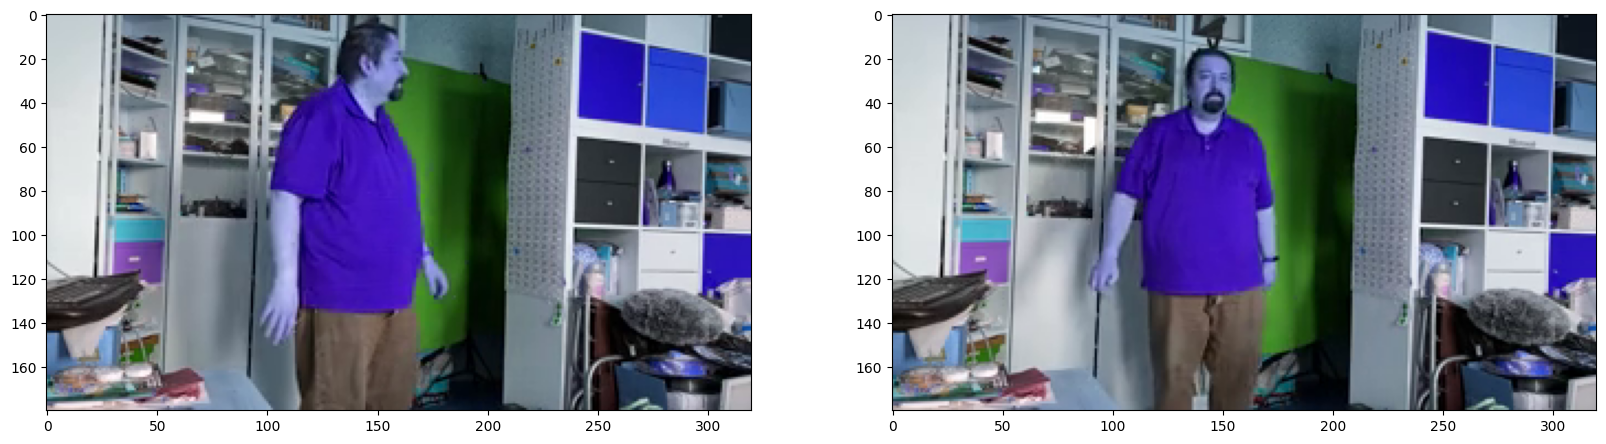

In [20]:
for event in events:
    print(f"Event from frame {event[0]} to frame {event[-1]}")
    
fig, axs = plt.subplots(1, len(events), figsize=(20, 20))
for i in range(len(events)):
    # Frame central de l'event
    frame = events[i][len(events[i])//2]
    axs[i].imshow(frames[frame])

Podem veure com el color de les imatges no es el correcte, ja quenles persones, per exemple, es veuen amb colors blavosos. Aixó es deu a que OpenCV carrega les imatges en format BGR,(per qüestions històriques de compatibilitat) i Matplotlib les mostra en format RGB. Per això, hem de convertir les imatges a format RGB abans de mostrar-les. Això ho podem fer amb la funció `cv2.cvtColor`.

Aquí ho farem abans de mostrar però sol ser bona idea fer-ho abans de processar les imatges.

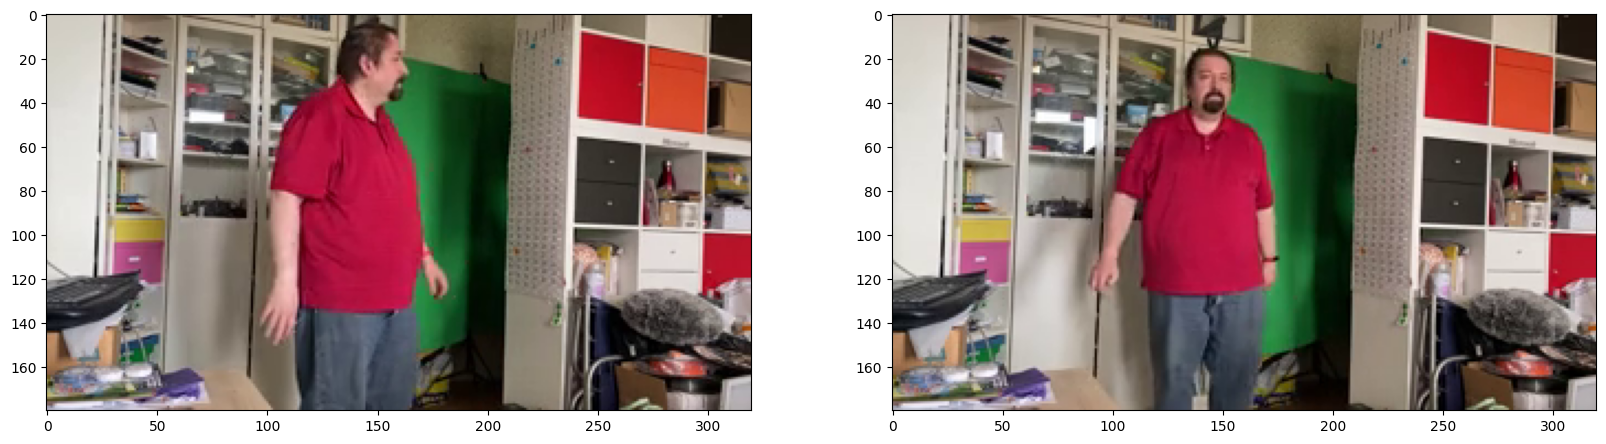

In [21]:
frames_rgb = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames]

fig, axs = plt.subplots(1, len(events), figsize=(20, 20))
for i in range(len(events)):
    # Frame central de l'event
    frame = events[i][len(events[i])//2]
    axs[i].imshow(frames_rgb[frame])

## Flux òptic

El flux òptic és un altre mètode per a detectar moviment. Aquest mètode calcula el moviment de cada píxel entre dos frames consecutius. Això ens permetrà calcular la direcció i la velocitat del moviment de cada píxel. Es més costós pero ens permetrà calcular la direcció i la velocitat del moviment.

El flux òptic es pot calcular amb la funció `cv2.calcOpticalFlowFarneback`. Aquesta funció retorna un array amb el moviment de cada píxel entre dos frames consecutius.

In [24]:
flows = [cv2.calcOpticalFlowFarneback(frames_bn[i], frames_bn[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0) for i in range(len(frames_bn)-1)]

flows[0].shape

(180, 320, 2)

Cada flow té el tamany de la imatge i conté dos valors: el moviment horitzontal i el vertical.

Representar el flux òptic en 2D és una mica complicat, però podem utilitzar una idea intel·ligent. Si convertim el flux òptic a coordenades polars, obtindrem dos components per a cada píxel: direcció i intensitat. Podem representar la intensitat amb la intensitat del píxel, i la direcció amb diferents colors. Crearem una imatge en l'espai de colors HSV (Hue-Saturation-Value), on el matís estarà definit per la direcció, el valor per la intensitat, i la saturació serà 255.

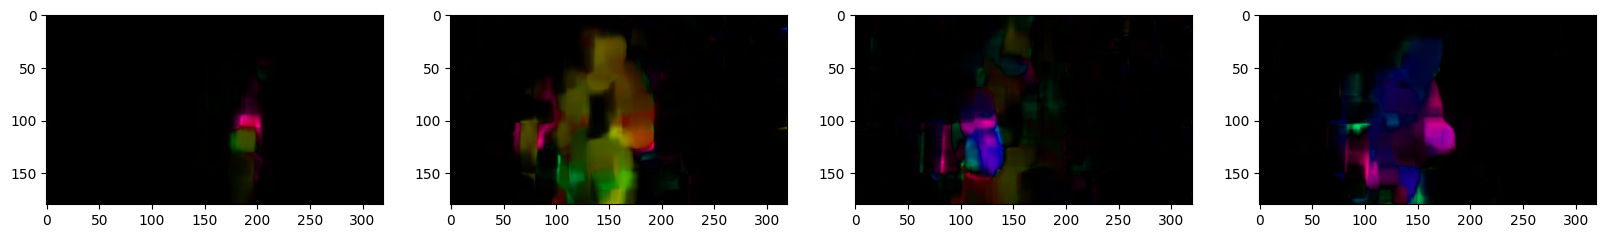

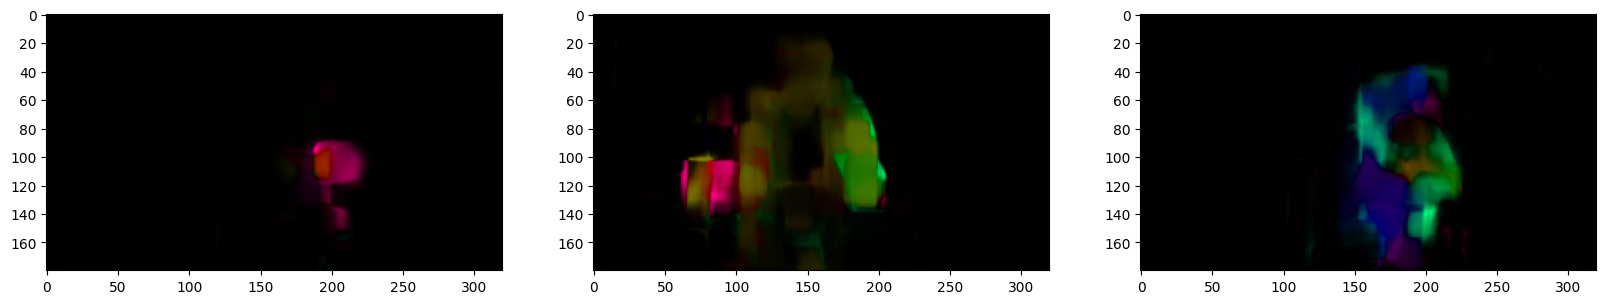

In [40]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)


for event in events:
    start = event[0]
    stop = event[-1]
    frms = [flow_to_hsv(x) for x in flows[start:stop]]

    fig, axs = plt.subplots(1, len(frms)//25 + 1, figsize=(20, 20))
    for i, flow in enumerate(frms[::25]):
        axs[i].imshow(flow)


En aquestos frames el color verdós correspon a moviment a l'esquerra, mentre que el blau a la dreta.

El flux òptic pot ser una eina molt útil per a treure conclusions sobre la direcció general del moviment. Per exemple, si veiem que tots els píxels d'una imatge es mouen més o menys en una direcció, podem concloure que hi ha moviment de la càmera, i intentar compensar-ho.